In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import glob
import pandas as pd
import os
import numpy as np
import h5py
from atlasify import atlasify
import atlas_mpl_style as ampl
import matplotlib.pyplot as plt

## check available datasets

In [2]:
data_template = 'conversion/pt{}_taus/'
avail = glob.glob(data_template.format('*'))
print('available datasets:', avail)

available datasets: ['conversion/pt500_taus/']


## convert datasets, if not already done

In [3]:
const_names = ['Eta', 'Phi', 'Mass', 'Pt']
hlf_names = [
    'Eta',
    'Phi',
    'Charge',
    'EhadOverEem',
    'PT',
    'Mass',
    'NCharged',
    'NNeutrals',
    'NSubJetsPruned',
    'NSubJetsSoftDropped',
    'PTD',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
    'event_number',
    'jet_number',
]

In [4]:
def make_df_from_constituents(const_list):
    comb = np.concatenate(const_list)
    index = pd.MultiIndex.from_product([range(s) for s in comb.shape[:-1]] + [const_names], names=['count', 'const', 'var'])
    ser = pd.Series(comb.flatten(), index=index).unstack('var')
    return ser[~(ser < 0).all(axis=1)]

def make_df_from_hlf(hlf_list):
    comb = np.concatenate(hlf_list)
    df = pd.DataFrame(comb, columns=hlf_names)
    df.index.name = 'count'
    df.columns.name = 'var'
    return df

force = False
for data_name in avail:
    save_head = 'data'
    for kind in ['dijet', 'ttbar']:

        save_name = os.path.join(save_head, data_name.split('/')[1])
        
        hlf_path = '{}_{}_hlf'.format(save_name, kind)
        if os.path.exists(hlf_path) and (not force):
            hlf_path = None

        const_path = '{}_{}_const'.format(save_name, kind)
        if os.path.exists(const_path) and (not force):
            const_path = None

        if const_path is None and hlf_path is None:
            continue

        files = glob.glob(os.path.join(data_name, '{}_out/*/data.h5'.format(kind)))
        hlf_list = []
        const_list = []

        for fname in files:
            with h5py.File(fname, 'r') as fread:
                hlf_list.append(fread['hlf'][:])
                const_list.append(fread['const'][:])

        hlf_df = make_df_from_hlf(hlf_list)
        const_df = make_df_from_constituents(const_list)

        if hlf_path is not None:
            print('writing to {}'.format(hlf_path))
            hlf_df.to_pickle(hlf_path)
        if const_path is not None:
            const_df.to_pickle(const_path)
            print('writing to {}'.format(const_path))
        del hlf_df
        del const_df
        del hlf_list
        del const_list

In [5]:
def load_data(pt=200, const=False):
    fmt = data_template.format(pt).split('/')[1]
    ret = (
        pd.read_pickle('data/{}_dijet_hlf'.format(fmt)),
        pd.read_pickle('data/{}_ttbar_hlf'.format(fmt)),
    )
    if const:
        ret = ret + (
            pd.read_pickle('data/{}_dijet_const'.format(fmt)),
            pd.read_pickle('data/{}_ttbar_const'.format(fmt)),
        )
    return ret

hlf, tthlf, const, ttconst = load_data(pt=500, const=1)

In [6]:
hlf['tau21'] = hlf.tau2/(hlf.tau1 + 1e-12)
hlf['tau32'] = hlf.tau3/(hlf.tau2 + 1e-12)

tthlf['tau21'] = tthlf.tau2/(tthlf.tau1 + 1e-12)
tthlf['tau32'] = tthlf.tau3/(tthlf.tau2 + 1e-12)

## feature plots

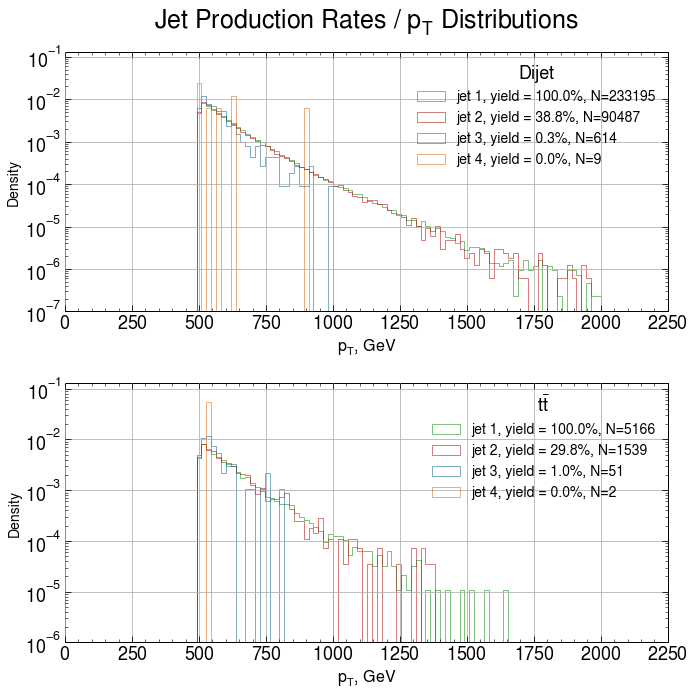

In [12]:
from atlasify import atlasify
import atlas_mpl_style as ampl
import matplotlib.pyplot as plt

ampl.use_atlas_style()

fig,axs = plt.subplots(2,1,figsize=(10,10))

pt_bins = np.linspace(200, 2000, 100)
pt_x = pt_bins[:-1] + 0.5*np.diff(pt_bins)

for i,(ax,hlf_group,hlf_name) in enumerate(zip(axs[:2], [hlf, tthlf], ['Dijet', r'$t\bar{t}$'])):
    for n,group in hlf_group.groupby('jet_number').PT:
        if n == 0:
            n0 = len(group)
        if n < 4:
            ax.hist(group, bins=pt_bins, label='jet {}, yield = {:.1f}%, N={:<3}'.format(int(n+1), 100*len(group)/n0, len(group)), histtype='step', density=1)
    ax.set_yscale('log')
    ax.legend(title=hlf_name, fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xlabel('$p_T$, GeV', fontsize=16)
    ax.grid()
    atlasify(axes=ax, atlas=False)
axs[0].set_title('Jet Production Rates / $p_T$ Distributions', fontsize=25, y=1.07)
plt.tight_layout()
plt.savefig('plots/jet_production_rates.pdf', bbox_inches='tight')
plt.show()

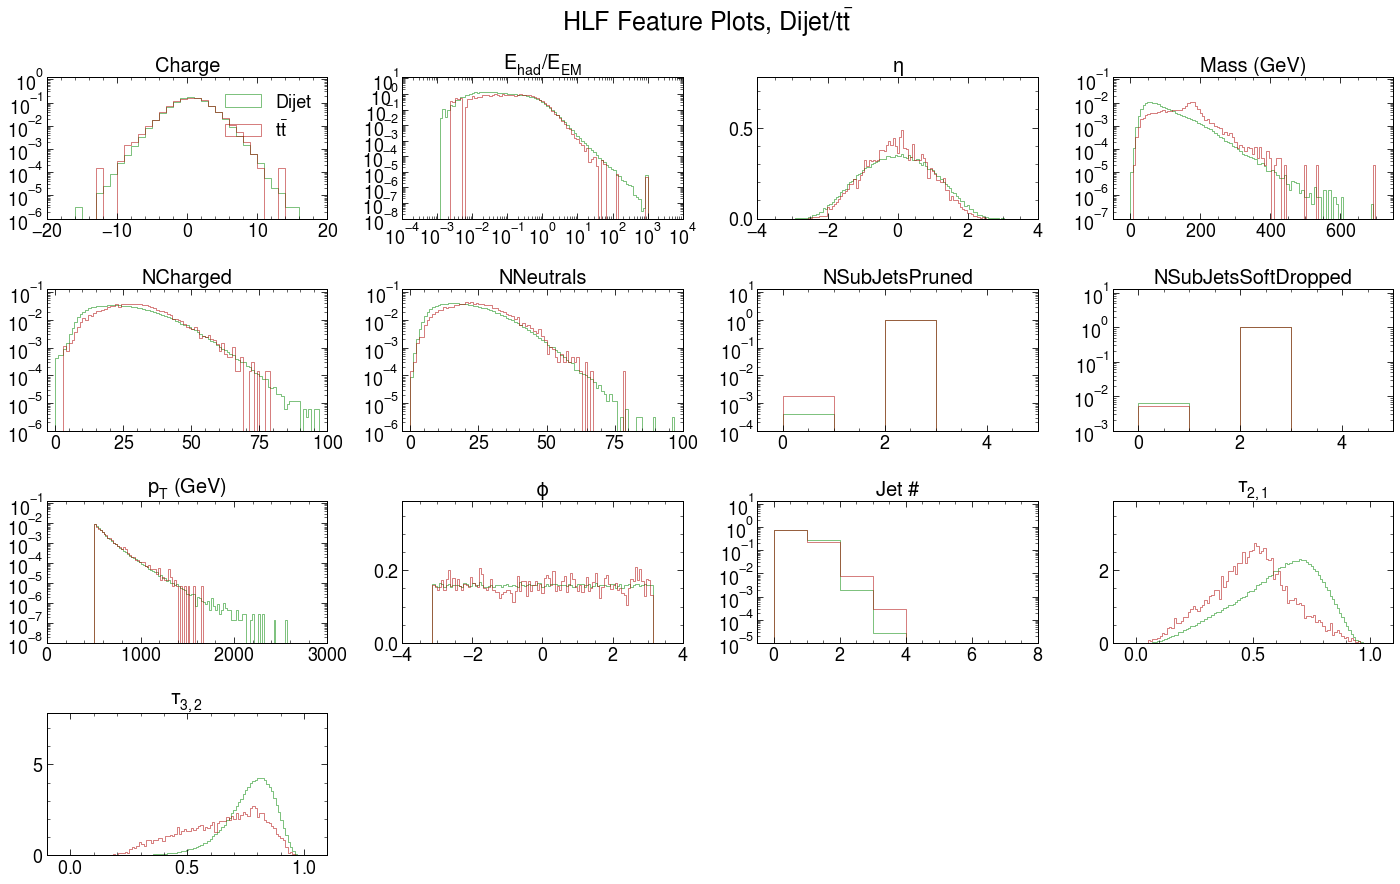

In [13]:
ampl.use_atlas_style()

names = sorted([l for l in hlf.columns if l not in ['event_number', 'PTD', 'tau1', 'tau2', 'tau3', 'tau4']])
N = len(names)
cols = 4
w,h = 5, 3

params_dict = {
    'Eta': {'name': '$\eta$'},
    'Phi': {'name': '$\phi$'},
    'Charge': {'bins': np.arange(-20, 20.1, 1), 'xlim': (-20, 20), 'yscale': 'log'},
    'EhadOverEem': {'name': '$E_{had}/E_{EM}$', 'yscale': 'log', 'xlim': (1e-4, 1e4), 'bins': np.logspace(-3, 4, 100), 'xscale': 'log'},
    'PT': {'name': '$p_T$ (GeV)', 'yscale': 'log'},
    'Mass': {'name': 'Mass (GeV)', 'yscale': 'log', 'xlim': (-50, 750)},
    'NCharged': {'bins': np.arange(0, 100, 1), 'xlim': (-3, 100), 'yscale': 'log'},
    'NNeutrals': {'bins': np.arange(0, 100, 1), 'xlim': (-3, 100), 'yscale': 'log'},
    'NSubJetsPruned': {'bins': np.arange(0, 6.1, 1), 'density': 1, 'xlim': (-.5, 5), 'yscale': 'log'},
    'NSubJetsSoftDropped': {'bins': np.arange(0, 6.1, 1), 'density': 1, 'xlim': (-.5, 5), 'yscale': 'log'},
    'jet_number': {'bins': np.arange(0, 8, 1), 'density': 1, 'xlim': (-.5, 8), 'yscale': 'log', 'name': 'Jet #'},
    'tau21': {'name': r'$\tau_{2,1}$','bins': np.linspace(0,1,100), 'xlim':(-.1, 1.1)},
    'tau32': {'name': r'$\tau_{3,2}$','bins': np.linspace(0,1,100), 'xlim':(-.1, 1.1)}
}

rows = int(np.ceil(N/cols))
fig,axs = plt.subplots(rows, cols, figsize=(cols*w, rows*h))

for i,(ax,name) in enumerate(zip(axs.flatten(), names)):
    params = params_dict[name] if name in params_dict else {}
    if 'bins' in params:
        bins = params['bins']
    else:
        bins = np.linspace(min([hlf[name].min(), tthlf[name].min()]), max([hlf[name].max(), tthlf[name].max()]), 100)
        
    ax.hist(hlf[name], bins=bins, histtype='step', density=params['density'] if 'density' in params else 1, label='Dijet')
    ax.hist(tthlf[name], bins=bins, histtype='step', density=params['density'] if 'density' in params else 1, label=r'$t\bar{t}$')
    ax.set_title(name if 'name' not in params else params['name'])
    if 'yscale' in params: ax.set_yscale(params['yscale'])
    if 'xscale' in params: ax.set_xscale(params['xscale'])
    if 'ylim' in params: ax.set_ylim(*params['ylim'])
    if 'xlim' in params: ax.set_xlim(*params['xlim'])
    atlasify(axes=ax, atlas=False)
    if i > 0:
        ax.get_legend().remove()
for j in range(i+1, cols*rows):
    axs.flatten()[j].axis('off')
axs[0,0].legend()
plt.tight_layout()
fig.suptitle(r'HLF Feature Plots, Dijet/$t\bar{t}$', fontsize=25, y=1.03)
plt.savefig('plots/all_hlf_features.pdf', bbox_inches='tight')
plt.show()

## data

In [7]:
hlf_to_train = [
    # 'Eta',
    # 'Phi',
    'Charge',
    'EhadOverEem',
    'PT',
    'Mass',
    'NCharged',
    'NNeutrals',
    'tau21',
    'tau32',
]

from sklearn.model_selection import KFold

seed = 42
N_kfolds = 4
shuffle = False

# significances of signal injection
injection_fracs = np.array([0., .005, 0.01, .02])

max_bkg = -1
if max_bkg < 0:
    max_bkg = len(hlf)

N_bkg = min((len(hlf), max_bkg))

N_sigs = np.round(injection_fracs*N_bkg).astype(int)
# N_sigs = np.round(np.sqrt(N_bkg - N_bkg/N_kfolds)*injection_sigs).astype(int)

data_x = [pd.concat([hlf.sample(N_bkg, random_state=seed), tthlf.sample(N_sig, random_state=seed)]).reset_index(drop=True) for N_sig in N_sigs]
data_y = [pd.Series(np.concatenate([np.zeros(N_bkg), np.ones(N_sig)]), index=data_x[i].index) for i,N_sig in enumerate(N_sigs)]
data_ttbar = [tthlf[~tthlf.index.isin(tthlf.sample(N_sig, random_state=seed).index)].reset_index(drop=True) for N_sig in N_sigs]

kf = KFold(N_kfolds, shuffle=True, random_state=seed)
fraction = 1/N_kfolds

train_test_idx = [[(data_x[i].index[sp[0]], data_x[i].index[sp[1]]) for sp in list(kf.split(data_x[i].index))] for i in range(len(data_x))]

In [269]:
import warnings
ampl.use_atlas_style()

warnings.filterwarnings('ignore', 'RuntimeWarning')

def minmax_norm(train, test, features):
    
    f_app = lambda x: (x - mi)/(ma - mi)
    train_c, test_c = train.copy(), test.copy()
    if 'EhadOverEem' in train:
        train_c['EhadOverEem'] = np.log(train_c.EhadOverEem + 1e-3)
        test_c['EhadOverEem'] = np.log(test_c.EhadOverEem + 1e-3)
    mi, ma = train_c[features].min(), train_c[features].max()
    
    tr,te = f_app(train_c[features]), f_app(test_c[features])
    
    return tr, te

def plot_train_test_datasets(train, test, ttbar=None, labels=['train', 'test', 'ttbar'], save_path=None, show=True, title='No Title', n_bins=50, ncols=3, figh=6, figw=7, frac_size=0.33):
    rows,cols = int(np.ceil(len(train.columns)/ncols)),int(ncols)

    fig, axs = plt.subplots(2*rows, cols, figsize=(cols*figw, rows*figh), gridspec_kw={'height_ratios': [1, frac_size,]*rows})

    axs = axs.T.reshape(cols, rows, -1).reshape(cols*rows,-1)
    
    ranges = pd.concat([pd.concat([train,test,ttbar]).min(), pd.concat([train, test, ttbar]).max()], axis=1)
    for i,f in enumerate(train.columns):
        bins = np.linspace(*ranges.loc[f], n_bins)
        
        axs[i,0].hist(train[f], histtype='step', bins=bins, density=1, label=labels[0])
        axs[i,0].hist(test[f], histtype='step', bins=bins, density=1, label=labels[1])
        if ttbar is not None:
            axs[i,0].hist(ttbar[f], histtype='step', bins=bins, density=1, label=labels[2])
        
        if f.startswith('M'): 
            axs[i,0].set_yscale('log')
        tr = np.histogram(train[f], bins=bins)[0]
        tr_normc = (np.diff(bins)*tr).sum()
        te = np.histogram(test[f], bins=bins)[0]
        te_normc = (np.diff(bins)*te).sum()
        for e in [-2, 0, 2]:
            axs[i,1].axhline(e, color='tab:grey', ls=':' if abs(e)>0 else '-')
        axs[i,1].axhspan(-1, 1, color='tab:grey', alpha=0.3)
        axs[i,1].plot(np.diff(bins)*.5 + bins[:-1], (te/te_normc - tr/tr_normc)/(np.sqrt(1e-8 + te/(te_normc**2.) + tr/(tr_normc**2.))),color='black', marker='o')
        axs[i,1].set_ylim(-5, 5)
        axs[i,1].set_yticks(np.arange(-4, 4.01, 2))
        axs[i,1].set_ylabel('(test - train)/\nerror')
        axs[i,0].set_ylabel('Count')
        axs[i,1].set_xlabel('{}, normalized'.format(f), fontsize=15)
        if i == 0:
            axs[i,0].legend()
    for j in range(i+1, len(axs)):
        axs[j,0].axis('off')
        axs[j,1].axis('off')
    
    fig.suptitle(title, fontsize=26, y=.96, va='bottom')
#         axs[i,0].set_xticks([])
#         axs[i,0].set_xlim(axs[i,1].get_xlim())
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
        
def create_history_series(history, kfold_n, injection_frac, model_name):
    hist_df = pd.DataFrame(history.history).stack().swaplevel(0,1).sort_index()
    hist_df.index.names = ['metric', 'epoch']

    for idx_key, idx_name in zip([kfold_n, injection_frac, model_name], ['kfold', 'sb_ratio', 'model']):
        hist_df = pd.concat({idx_key: hist_df}, names=[idx_name])
    return hist_df

def update_pickle(key, new, path):
    comb = None
    if os.path.exists(path):
        comb = pd.read_pickle(path)
    if comb is not None:
        if key in comb.index:
            return
    comb = pd.concat([comb, new])
    comb.to_pickle(path)

def load_pickle(path):
    return pd.read_pickle(path)

def create_data_series(res, kfold_n, injection_frac, model_name):
    df = res.stack()
    for idx_key, idx_name in zip([kfold_n, injection_frac, model_name], ['kfold', 'sb_ratio', 'model']):
        df = pd.concat({idx_key: df}, names=[idx_name])
    return df

def check_data_key(key, path):
    exists = False
    try:
        exists = key in load_pickle(path).index
    except FileNotFoundError:
        pass
    return exists

In [285]:

from tensorflow.keras import layers
from tqdm.notebook import tqdm
from keras import backend as K




def variational_AE(columns=hlf_to_train, intermediate_dim=32, latent_dim=4):
    # This is the size of our encoded representations
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon
    original_dim = len(hlf_to_train)
    inputs = keras.Input(shape=(original_dim,))
    h = layers.Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])
    # Create encoder
    encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = layers.Dense(original_dim, activation='sigmoid')(x)
    decoder = keras.Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = keras.Model(inputs, outputs, name='vae_mlp')
    
    reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae

N_early_stopping_epochs = 10
N_epochs = 200
batch_size = 500
verbose = True
model_name = 'variational2'
title_desc = '{} model | S/B = {} | Kfold #{}'
plot_desc = 'plots/train_test_verifications/{}-model_{}-sbr_kfold-{}.pdf'

data_save_path = 'results/results_{}-model.pkl'.format(model_name)
hist_save_path = 'results/history_{}-model.pkl'.format(model_name)

pbar = tqdm(
    total=len(injection_fracs)*len(train_test_idx),
)

for i,frac in enumerate(injection_fracs):
    x, y, tt = data_x[i], data_y[i], data_ttbar[i]
    
    for kfold,(train_idx, test_idx) in enumerate(train_test_idx[i]):
        
     
        key = (model_name, frac, kfold)
        pbar.set_description(title_desc.format(*key))
        
        if not check_data_key(key, data_save_path):
            x_train, x_test, y_train, y_test = x.loc[train_idx], x.loc[test_idx], y[train_idx], y[test_idx]
            x_tr_norm, x_te_norm = minmax_norm(x_train, x_test, hlf_to_train)

            _, x_ttbar_norm = minmax_norm(x_train, tt, hlf_to_train)

            model = variational_AE()

            # add a callback
            callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=N_early_stopping_epochs)

            # plot and save normalized data, right before saving
            plot_train_test_datasets(
                x_tr_norm, x_te_norm, x_ttbar_norm, title=title_desc.format(*key), 
                save_path=plot_desc.format(*key), show=False
            )

            # fit model
            history = model.fit(
                x=x_tr_norm.values,
                y=x_tr_norm.values,
                validation_data=(
                    x_te_norm.values,
                    x_te_norm.values
                ),
                epochs=N_epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=verbose,
                callbacks=[callback],
            )

            # update_pickle(
            #     key,
            #     create_history_series(history, *reversed(key)),
            #     hist_save_path
            # )
            # raise Exception()
            
            x_eval_norm = pd.concat([x_te_norm, x_ttbar_norm]).reset_index(drop=1)
            y_eval = np.concatenate([y_test, np.ones(len(x_ttbar_norm))])
            is_kfold = kfold*np.ones_like(y_eval)
            kfold_part_tag = np.concatenate([np.ones_like(y_test), np.zeros(len(x_ttbar_norm))])

            x_eval_normhat = model.predict(x_eval_norm)
            x_err_norm = x_eval_norm - x_eval_normhat
            y_eval_hat = keras.losses.binary_crossentropy(x_eval_norm.values, x_eval_normhat).numpy()

            res = pd.concat([pd.DataFrame({'y': y_eval, 'yhat': y_eval_hat, 'kfold': is_kfold, 'in_fold': kfold_part_tag}, ), x_eval_norm.reset_index(drop=True)], axis=1)
            res.index.name = 'count'

            # update_pickle(
            #     key,
            #     create_data_series(res, *reversed(key)),
            #     data_save_path
            # )
            raise Exception()

        pbar.update(1)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/200
487/487 [==============================] - 1s 2ms/step - loss: 4.6354 - val_loss: 4.3226
Epoch 2/200
487/487 [==============================] - 1s 2ms/step - loss: 4.3027 - val_loss: 4.2861
Epoch 3/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2834 - val_loss: 4.2757
Epoch 4/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2759 - val_loss: 4.2727
Epoch 5/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2742 - val_loss: 4.2720
Epoch 6/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2734 - val_loss: 4.2707
Epoch 7/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2725 - val_loss: 4.2703
Epoch 8/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2721 - val_loss: 4.2693
Epoch 9/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2715 - val_loss: 4.2697
Epoch 10/200
487/487 [==============================] - 1s 2ms/step - loss: 4.2712 - val_lo

Exception: 

In [286]:
encoder = model.get_layer('encoder')

encode = encoder.predict(x_eval_norm)[2]

Text(0.5, 1.0, 'Example VAE Latent Space')

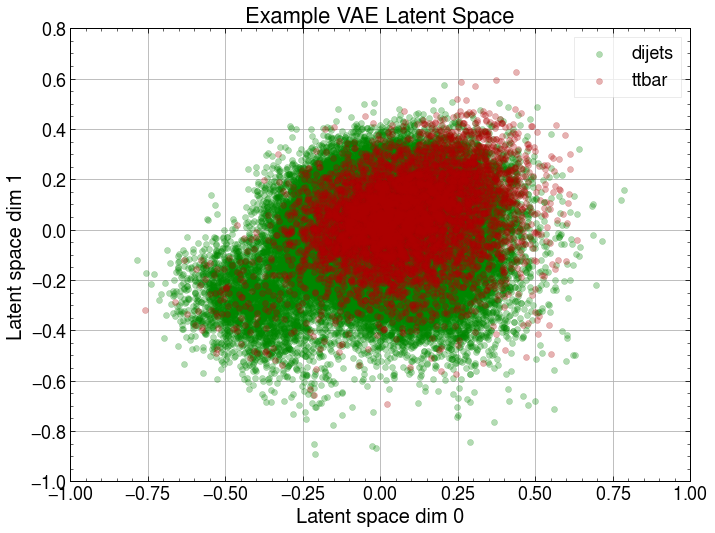

In [287]:
plt.scatter(encode[y_eval==0,0], encode[y_eval==0,1], alpha=.3, label='dijets')
plt.scatter(encode[y_eval==1,0], encode[y_eval==1,1], alpha=.3, label='ttbar')
plt.xlabel('Latent space dim 0')
plt.ylabel('Latent space dim 1')
plt.grid()
plt.legend(frameon=1)
plt.gca().set_axisbelow(True)
plt.title('Example VAE Latent Space', fontsize=22)
plt.savefig('plots/vae_latent_space.pdf', bbox_inches='tight')

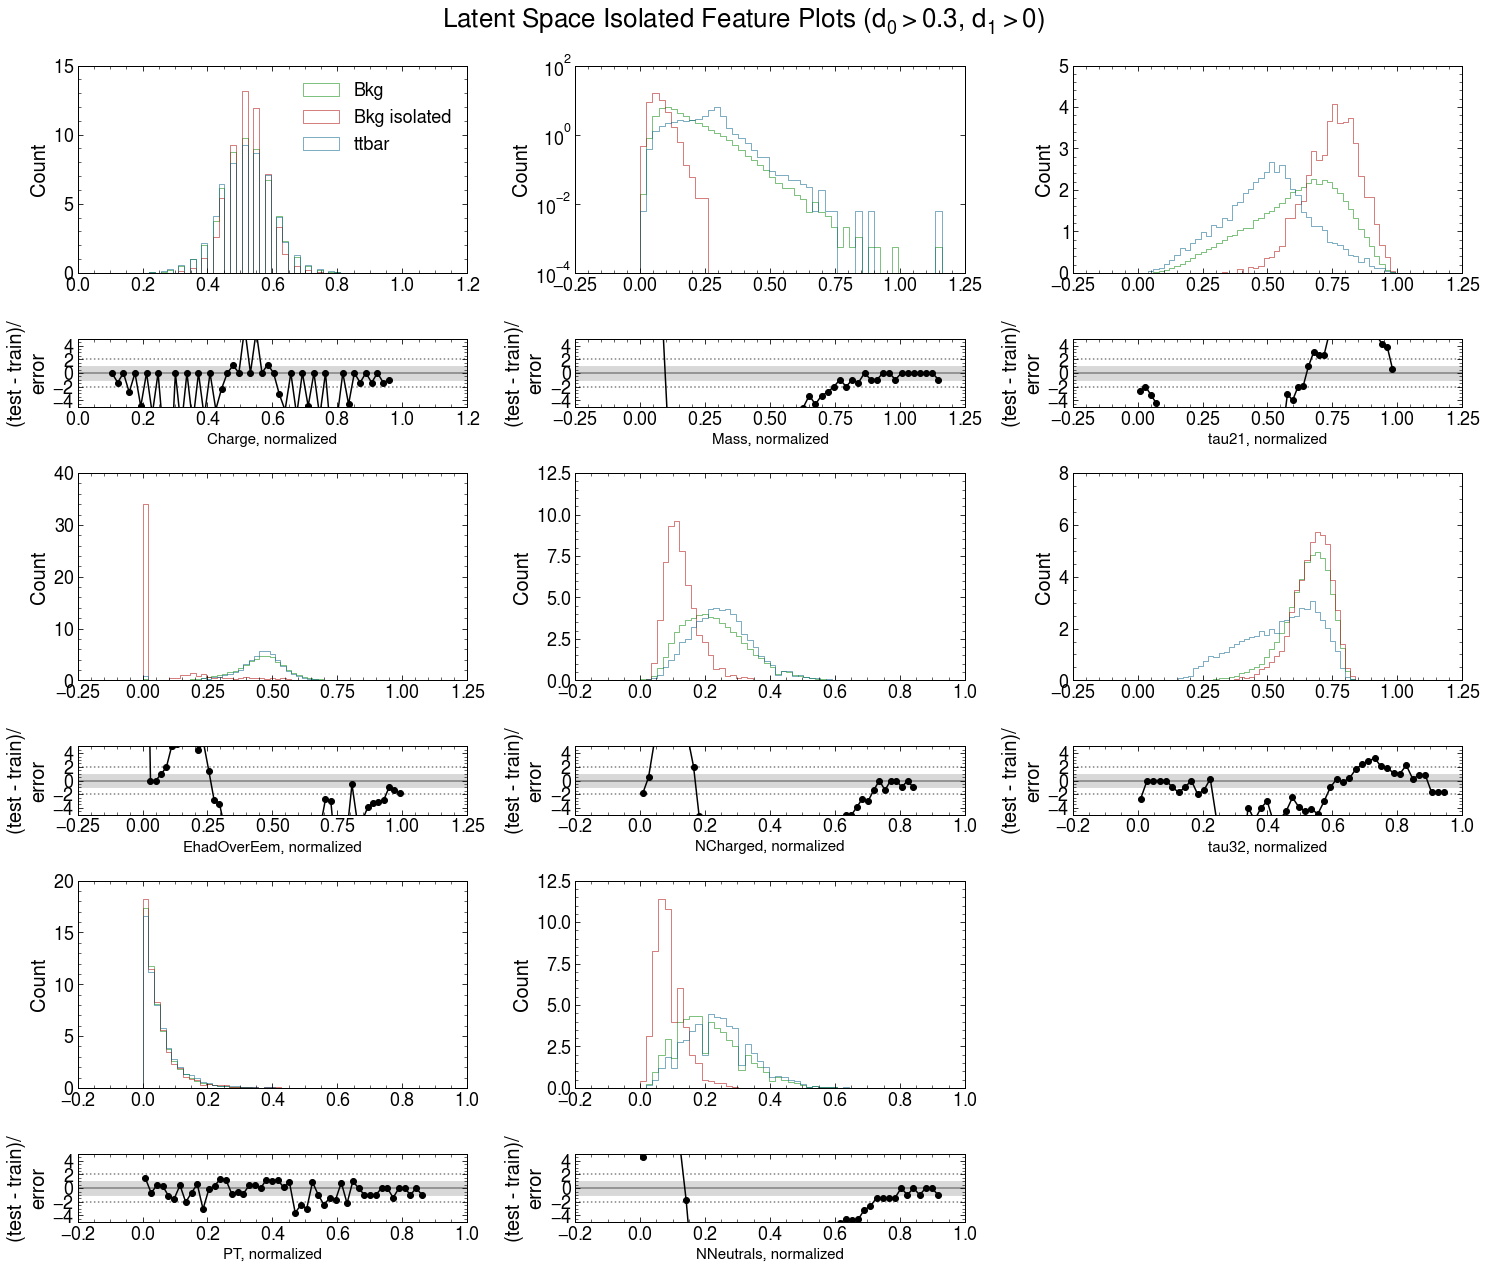

In [270]:
idx = (encode[:,0] < -.25) & (encode[:,1] < 0) & (y_eval == 0)
idxn = (y_eval==0)&(~idx)
idxt = y_eval==1

plot_train_test_datasets(
    x_eval_norm[idxn], x_eval_norm[idx], x_eval_norm[idxt],
    title='Latent Space Isolated Feature Plots ($d_0 < -0.25$, $d_1 < 0$)',
    labels=['Bkg', 'Bkg isolated', 'ttbar'],
    save_path='plots/latent_isolate_features.pdf', show=True
)


In [252]:
ls

analysis.ipynb  data/   README.md  simple.py  tests.ipynb
conversion/     plots/  results/   tests/     variational.py


# Analyze results

In [159]:
model_name = 'simpleTEST'
dsp_st = 'results/results_{}-model.pkl'.format(model_name)
hsp_st = 'results/history_{}-model.pkl'.format(model_name)
simplet = load_pickle(dsp_st).unstack(-1)

model_name = 'simple'
dsp_s = 'results/results_{}-model.pkl'.format(model_name)
hsp_s = 'results/history_{}-model.pkl'.format(model_name)
simple = load_pickle(dsp_s).unstack(-1)

model_name = 'variational'
dsp_v = 'results/results_{}-model.pkl'.format(model_name)
hsp_v = 'results/history_{}-model.pkl'.format(model_name)
var = load_pickle(dsp_v).unstack(-1)

sb_ratio  kfold
0.000     0        0.565557
          1        0.545366
          2        0.523464
          3        0.535388
0.005     0        0.567860
          1        0.520860
          2        0.509890
          3        0.570775
0.010     0        0.500646
          1        0.513510
          2        0.597532
          3        0.525847
0.020     0        0.540121
          1        0.549671
          2        0.497426
          3        0.525593
dtype: float64

In [188]:
const

var                Eta          Mass       Phi         Pt
count  const                                             
0      0      0.242081  5.268356e-09 -2.494863   0.352214
       1     -0.545132 -7.450581e-09 -2.355830   0.518610
       2     -0.473407  1.490116e-08  2.736946   0.985643
       3      0.118179  1.490116e-08 -2.945840   1.232924
       4     -0.178871  0.000000e+00  2.867859   1.464579
...                ...           ...       ...        ...
324304 50    -0.250958 -4.214685e-08 -2.867750   3.846682
       51    -0.263829 -2.384186e-07 -2.875697  17.543182
       52    -0.281878  4.768372e-07 -2.869712  35.823521
       53    -0.298554 -2.384186e-07 -2.865505  18.326710
       54    -0.291214  0.000000e+00 -2.856964  58.613392

[14876526 rows x 4 columns]

/tmp/ipykernel_118577/3295458944.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  aucs = dset.groupby(level=('sb_ratio', 'kfold')).apply(lambda x: auc(x.y, x.yhat)).mean(level='sb_ratio')
/tmp/ipykernel_118577/3295458944.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  aucs = dset.groupby(level=('sb_ratio', 'kfold')).apply(lambda x: auc(x.y, x.yhat)).mean(level='sb_ratio')
/tmp/ipykernel_118577/3295458944.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  aucs = dset.groupby(level=

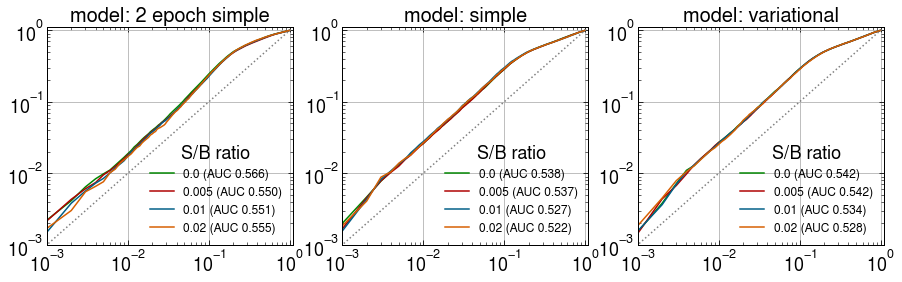

In [256]:
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc

def get_roc_points(delt, points=np.linspace(0,1,1000)):
    gps = delt.groupby(level=('sb_ratio', 'kfold')).apply(lambda x: interp1d(*roc_curve(x.y, x.yhat)[:2])(points))
    return pd.DataFrame(np.asarray(gps.values.tolist()), index=gps.index, columns=points)

pts = np.linspace(0,1,1000)
fig,axs = plt.subplots(1,3, figsize=(15, 4))
for dset, name, ax in zip([simplet, simple, var], ['2 epoch simple', 'simple', 'variational'], axs):
    rocs = get_roc_points(dset, pts)
    aucs = dset.groupby(level=('sb_ratio', 'kfold')).apply(lambda x: auc(x.y, x.yhat)).mean(level='sb_ratio')
    # rocs.groupby(level='sb_ratio').mean().T.plot(ax=ax)
    gb = rocs.groupby(level='sb_ratio').mean().T.rename({c: '{} (AUC {:.3f})'.format(c,aucs[c]) for c in aucs.index.values}, axis=1)
    gb.plot(ax=ax)
    ax.grid()
    ax.set_axisbelow(True)
    ax.plot([1e-7,2], [1e-7,2], ls=':', color='tab:grey')
    ax.legend(title = 'S/B ratio', fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-3,.1+1e0)
    ax.set_xlim(1e-3,.1+1e0)
    ax.set_title('model: ' + name)
plt.savefig('plots/model_ROC_curves.pdf', bbox_inches='tight')

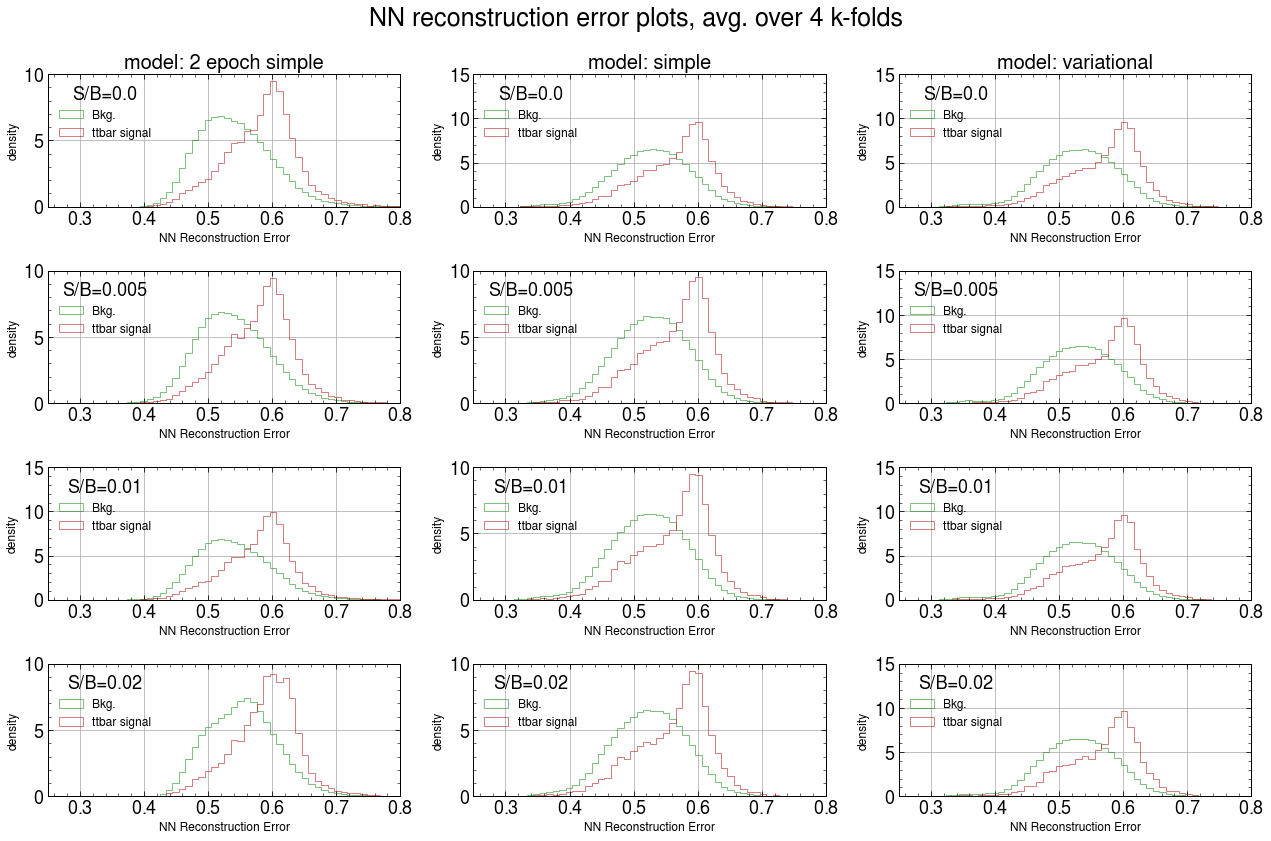

In [257]:
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc
rowiter = simple.index.get_level_values('sb_ratio').unique().values
colors = {r: plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i,r in enumerate(rowiter)}
fig,axes = plt.subplots(len(rowiter),3, figsize=(18, 3*len(rowiter)))
for dset, name, axs in zip([simplet, simple, var], ['2 epoch simple', 'simple', 'variational'], axes.T):
    # rocs = get_roc_points(dset, pts)
    # # rocs.groupby(level='sb_ratio').mean().T.plot(ax=ax)
    # rocs.groupby(level='sb_ratio').mean().T.plot(ax=ax)
    # dset.groupby(level='sb_ratio').yhat.hist(ax=ax, histtype='step', bins=np.linspace(0, 1, 100))
    for (sb_ratio,g),ax in zip(dset.groupby(level='sb_ratio'), axs):
        ax.hist(g.yhat[g.y==0], label='Bkg.', histtype='step', bins=np.linspace(0, 1, 100), density=1)
        ax.hist(g.yhat[g.y==1], label='ttbar signal', histtype='step', bins=np.linspace(0, 1, 100), density=1)
        
        ax.grid()
        ax.set_axisbelow(True)
        ax.set_xlim(.25, .8)
        ax.legend(loc='upper left', fontsize=12, title='S/B={}'.format(sb_ratio))
        ax.set_ylabel('density', fontsize=12)
        ax.set_xlabel('NN Reconstruction Error', fontsize=12)
# #     # ax.plot([1e-7,2], [1e-7,2], ls=':', color='tab:grey')
# #     ax.legend(title = 'S/B ratio', fontsize=12)
#     # axs[0].set_yscale('log')
# #     # ax.set_xscale('log')
# #     # ax.set_ylim(1e-3,.1+1e0)
# #     # ax.set_xlim(1e-3,.1+1e0)

    axs[0].set_title('model: ' + name)
fig.suptitle('NN reconstruction error plots, avg. over 4 k-folds', fontsize=25)
plt.tight_layout()
plt.savefig('plots/reconstruction_error_plots.pdf', bbox_inches='tight')

In [ ]:
x_eval_norm

var,Charge,EhadOverEem,PT,Mass,NCharged,NNeutrals,tau21,tau32
0,0.517658,0.458410,0.047596,0.124183,0.210307,0.191925,0.699517,0.658376
1,0.520334,0.428546,0.041556,0.088425,0.144957,0.127725,0.694504,0.668304
2,0.515220,0.467661,0.054745,0.200966,0.298511,0.282183,0.595209,0.642133
3,0.517589,0.453632,0.047193,0.109279,0.211129,0.191032,0.780988,0.664287
4,0.516565,0.462376,0.050612,0.152731,0.247228,0.229117,0.665063,0.651815
...,...,...,...,...,...,...,...,...
87830,0.517990,0.467190,0.047760,0.150280,0.202295,0.187059,0.522510,0.648659
87831,0.514616,0.472563,0.056997,0.238681,0.324684,0.310671,0.515761,0.634935
87832,0.517448,0.459361,0.048125,0.128431,0.217469,0.198993,0.698902,0.657479
87833,0.516060,0.472684,0.053229,0.211730,0.268436,0.254537,0.456448,0.637162


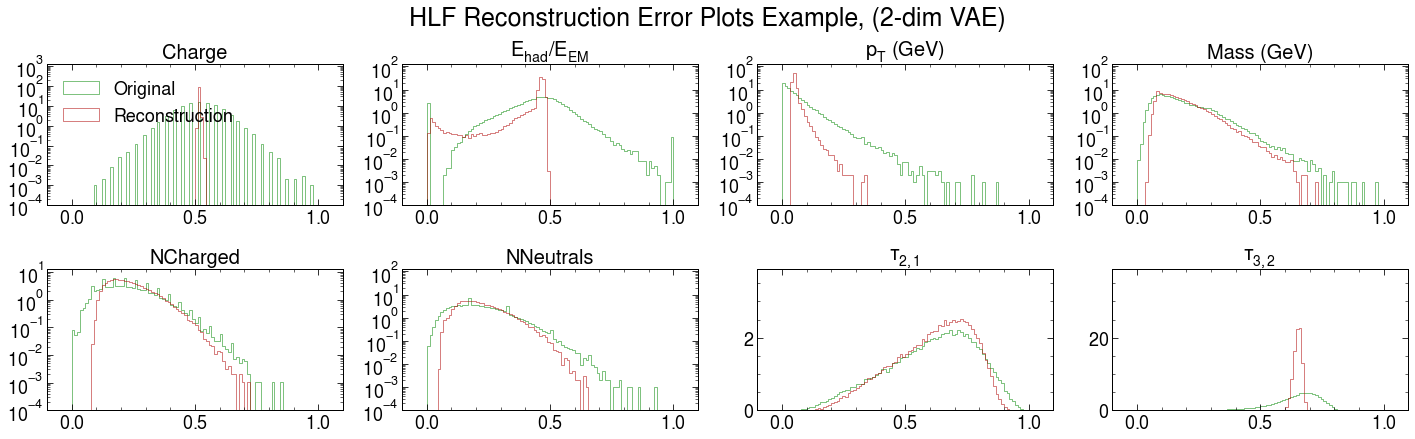

In [283]:
ampl.use_atlas_style()

names = hlf_to_train
N = len(names)
cols = 4
w,h = 5, 3
nh = pd.DataFrame(x_eval_normhat, columns=x_eval_norm.columns)
params_dict = {
    'Eta': {'name': '$\eta$'},
    'Phi': {'name': '$\phi$'},
    'Charge': {'bins': np.linspace(0, 1, 1), 'xlim': (-20, 20), 'yscale': 'log'},
    'EhadOverEem': {'name': '$E_{had}/E_{EM}$', 'yscale': 'log', 'xlim': (1e-4, 1e4), 'bins': np.logspace(-3, 4, 100), 'xscale': 'log'},
    'PT': {'name': '$p_T$ (GeV)', 'yscale': 'log'},
    'Mass': {'name': 'Mass (GeV)', 'yscale': 'log', 'xlim': (-50, 750)},
    'NCharged': {'bins': np.arange(0, 100, 1), 'xlim': (-3, 100), 'yscale': 'log'},
    'NNeutrals': {'bins': np.arange(0, 100, 1), 'xlim': (-3, 100), 'yscale': 'log'},
    'NSubJetsPruned': {'bins': np.arange(0, 6.1, 1), 'density': 1, 'xlim': (-.5, 5), 'yscale': 'log'},
    'NSubJetsSoftDropped': {'bins': np.arange(0, 6.1, 1), 'density': 1, 'xlim': (-.5, 5), 'yscale': 'log'},
    'jet_number': {'bins': np.arange(0, 8, 1), 'density': 1, 'xlim': (-.5, 8), 'yscale': 'log', 'name': 'Jet #'},
    'tau21': {'name': r'$\tau_{2,1}$','bins': np.linspace(0,1,100), 'xlim':(-.1, 1.1)},
    'tau32': {'name': r'$\tau_{3,2}$','bins': np.linspace(0,1,100), 'xlim':(-.1, 1.1)}
}

rows = int(np.ceil(N/cols))
fig,axs = plt.subplots(rows, cols, figsize=(cols*w, rows*h))

for i,(ax,name) in enumerate(zip(axs.flatten(), names)):
    params = params_dict[name] if name in params_dict else {}
    if 'bins' in params:
        bins = params['bins']
    else:
        bins = np.linspace(min([hlf[name].min(), tthlf[name].min()]), max([hlf[name].max(), tthlf[name].max()]), 100)
    bins = np.linspace(-.1, 1, 100)
    ax.hist(x_eval_norm[name], bins=bins, histtype='step', density=params['density'] if 'density' in params else 1, label='Original')
    ax.hist(nh[name], bins=bins, histtype='step', density=params['density'] if 'density' in params else 1, label=r'Reconstruction')
    ax.set_title(name if 'name' not in params else params['name'])
    if 'yscale' in params: ax.set_yscale(params['yscale'])
    # if 'xscale' in params: ax.set_xscale(params['xscale'])
    if 'ylim' in params: ax.set_ylim(*params['ylim'])
    # if 'xlim' in params: ax.set_xlim(*params['xlim'])
    ax.set_xlim(-.1, 1.1)
    atlasify(axes=ax, atlas=False)
    
    if i > 0:
        ax.get_legend().remove()
for j in range(i+1, cols*rows):
    axs.flatten()[j].axis('off')
axs[0,0].legend(loc='upper left')
plt.tight_layout()
fig.suptitle(r'HLF Reconstruction Error Plots Example, (2-dim VAE)', fontsize=25, y=1.03)
plt.savefig('plots/reconstuction_dist_example.pdf', bbox_inches='tight')
plt.show()

In [60]:
def weighted_average(df, data_col, weight_col, by_col):
    df['_data_times_weight'] = df[data_col] * df[weight_col]
    df['_weight_where_notnull'] = df[weight_col] * pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result

avg_eta, avg_phi = (
    weighted_average(const.reset_index(), 'Eta', 'Pt', 'count'),
    weighted_average(const.reset_index(), 'Phi', 'Pt', 'count')
)

In [88]:
def angle_diff(a1, a2, deg=False):
    if not deg:
        a1, a2 = a1*180/np.pi, a2*180/np.pi
    diff = ((a2 - a1 + 180) % 360) - 180
    if not deg:
        return diff*np.pi/180
    return diff

In [111]:
diffs = angle_diff(const.Phi, hlf.Phi)

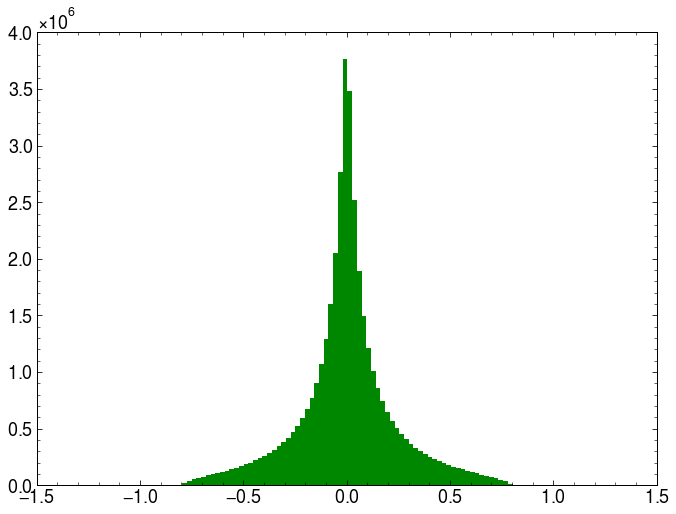

In [113]:
plt.hist(diffs, bins=100)
plt.show()

In [114]:
diffs

count   const
0       0        0.122852
        1        0.393453
        2        0.205358
        3       -0.270028
        4        0.058452
                   ...   
999999  63      -0.039502
        64      -0.229421
        65      -0.130264
        66      -0.090041
        67      -0.181781
Name: Phi, Length: 39968707, dtype: float64

In [109]:
avg_phi[70]

-0.55554639415823

In [110]:
const.Phi[70]

const
0    -2.246497
1     2.834912
2     2.795217
3    -2.989873
4     2.980012
5     3.117775
6    -3.128724
7     3.093133
8     2.793385
9     2.699676
10    2.825761
11   -2.600048
12   -2.481876
13    2.896344
14    2.900297
15    2.989051
16   -2.948421
17   -3.055780
18    3.121855
19   -3.091408
20   -2.941864
21   -2.899338
22   -3.082489
23   -3.010126
24   -2.964759
25   -2.860384
26   -2.947066
27   -2.952757
28   -2.697244
29   -2.762925
30   -2.829962
31   -2.809263
32   -2.858130
33   -2.788159
34   -2.799066
35   -2.823870
Name: Phi, dtype: float64

In [108]:
const.Phi[np.abs(diffs) > 1.2][70]

const
0    -2.246497
1     2.834912
2     2.795217
3    -2.989873
4     2.980012
5     3.117775
6    -3.128724
7     3.093133
8     2.793385
9     2.699676
10    2.825761
11   -2.600048
12   -2.481876
13    2.896344
14    2.900297
15    2.989051
16   -2.948421
17   -3.055780
18    3.121855
19   -3.091408
20   -2.941864
21   -2.899338
22   -3.082489
23   -3.010126
24   -2.964759
25   -2.860384
26   -2.947066
27   -2.952757
28   -2.697244
29   -2.762925
30   -2.829962
31   -2.809263
32   -2.858130
33   -2.788159
34   -2.799066
35   -2.823870
Name: Phi, dtype: float64

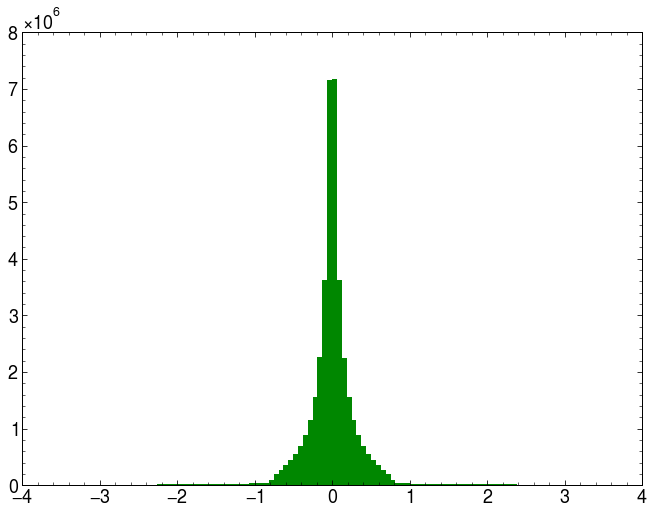

In [96]:
plt.hist(diffs, bins=100)
plt.show()

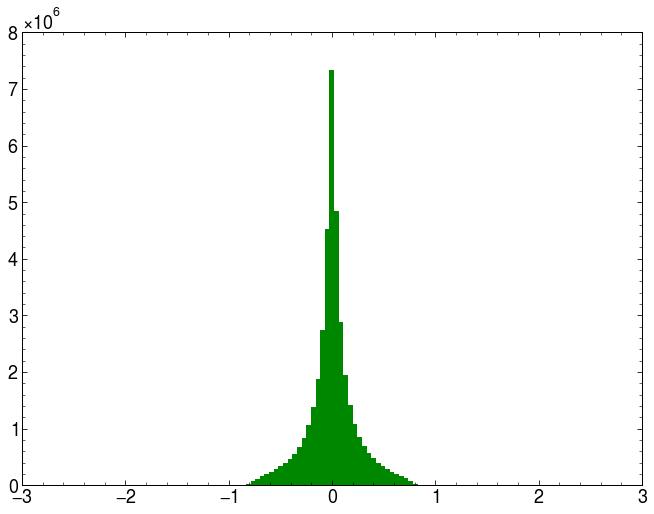

In [65]:
plt.hist(const.Eta - avg_eta, bins=100)
plt.show()

(39968707, 4)